In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

## Define functions

In [104]:
def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)
def f_loglin(x, x_c=1):
    return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))
def f_loglin_inv(y, y_c=0):
    return np.where(y < y_c, (1+y-y_c)*np.exp(y_c), np.exp(y))
def f_loglin_deriv(x, x_c=1):
    return np.where(x < x_c, 1/x_c, 1/x)

def f_mse(y, y_gt):
    return np.mean((y-y_gt)**2)/np.mean((y_gt)**2)

def desmear(Q,IQ,IQ_er,sigma_Q,n=3,sigmascale=1):
    I_ex = IQ
    I_ex_pos = I_ex[2*n:]
    I_ex_neg = I_ex[:-2*n]
    I_ex = I_ex[n:-n]
    sigma_Q_c = sigma_Q[n:-n]/sigmascale
    # sigma_Q_c = Q[n:-n]

    DQ = Q[n:] - Q[:-n]
    DQ_pos = DQ[n:]
    DQ_neg = DQ[:-n]

    I_ex2 = 2*(DQ_neg*I_ex_pos + DQ_pos*I_ex_neg - I_ex*(DQ_pos+DQ_neg))/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    I_des = I_ex - sigma_Q_c**2/2*I_ex2
    Q_des = Q[n:-n]

    # DI_ex = IQ_er
    # DI_ex[DI_ex==0] = np.min(DI_ex[DI_ex>0])
    # DI_ex_pos = DI_ex[2*n:]
    # DI_ex_neg = DI_ex[:-2*n]
    # DI_ex = DI_ex[n:-n]

    # DI_ex2_Sq = 4*((DQ_neg*DI_ex_pos)**2 + (DQ_pos*DI_ex_neg)**2 + ((DQ_neg+DQ_pos)*DI_ex)**2)/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    # DI_des = DI_ex*(1+sigma_Q_c**4/4*DI_ex2_Sq/DI_ex**2)
    
    return I_des

def f_log_likelihood(y, y_err, x, x_err, z_list = np.linspace(0, 0, 1), importance = None, index = None):
    """
    likelihood of y in the distribution of x
    """
    ## average over the ovservation uncertainty   
    log_likelihood = 0   
    sum_weight = 0  
    
    if importance is None:
        importance = np.ones(len(y))
    if index is None:
        index = np.arange(len(y))
    
    for z in z_list:
        weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
        y_z = y + y_err*z
        log_likelihood_z = -0.5 * np.sum((((y_z - x)**2 / x_err**2 + np.log(2 * np.pi * x_err**2))*importance)[index])
        log_likelihood += log_likelihood_z*weight_z
        sum_weight += weight_z
    log_likelihood = log_likelihood/sum_weight
    return log_likelihood

def gpr_core(
    q, I, I_err, I_bg, sigma_scale,
    f_I, f_I_deriv, f_Q, lmbda, index_eval
):
    """
    Shared GPR computation: returns posterior mean and std
    """

    y_data = f_I(I)
    y_bg = f_I(I_bg)
    y = y_data - y_bg
    y_err = I_err * f_I_deriv(I)

    if index_eval is None:
        index_eval = np.ones(len(y), dtype=bool)

    sig_var = np.mean(y[index_eval] ** 2)
    prior_sigma = np.sqrt(sig_var)

    def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
        if std_1 is None:
            std_1 = np.ones_like(q1)
        if std_2 is None:
            std_2 = np.ones_like(q2)
        return np.exp(-(q1[:, None] - q2[None, :])**2 / (2 * lmbda**2)) * std_1[:, None] * std_2[None, :]

    f_y_err = lambda err: sigma_scale**2 * (err**2 / sig_var)
    K_sigma = np.diag(f_y_err(y_err))

    q_tr = f_Q(q)
    K_xx = f_K_rbf(q_tr, q_tr, lmbda) + K_sigma
    K_xs = f_K_rbf(q_tr, q_tr, lmbda)
    k_ss = f_K_rbf(q_tr, q_tr, lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)

    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s) * prior_sigma**2
    std_s = np.sqrt(var_s)

    return mu_s, std_s, y, y_err, sig_var

def optimize_m_factor_gpr(
    q, I, I_err, I_bg,
    f_I=lambda I: I, f_inv_I=lambda fI: fI, f_I_deriv=lambda I: np.ones_like(I),
    f_Q=lambda q: q, lmbda=0.25, ax=None, color='k', index_eval=None, sigma_list = np.logspace(-1, 1, 10),
    q_min=None, q_max=None, ylim=[-5,5]
):
    sigma_list = sigma_list
    log_likelihood_list = []
    
    q_mask = (q >= q_min) & (q <= q_max) if q_min is not None and q_max is not None else np.ones_like(q, dtype=bool)

    for sigma in sigma_list:
        mu_s, std_s, y, y_err, _ = gpr_core(
            q=q, I=I, I_err=I_err, I_bg=I_bg, sigma_scale=sigma,
            f_I=f_I, f_I_deriv=f_I_deriv, f_Q=f_Q,
            lmbda=lmbda, index_eval=index_eval
        )
        log_likelihood = f_log_likelihood(
            y[q_mask], y_err[q_mask], mu_s[q_mask], std_s[q_mask], index=index_eval[q_mask]
        )
        log_likelihood_list.append(log_likelihood)
        print(f"current m_sigma: {sigma}, log_likelihood: {log_likelihood}")

    log_likelihood_list = np.array(log_likelihood_list)
    log_likelihood_list -= log_likelihood_list[-1]
    log_likelihood_list /= len(q)

    if ax is not None:
        ax.plot(sigma_list, log_likelihood_list, '-', color=color)
        ax.set_xscale('log')
        ax.set_ylim(ylim)
        ax.tick_params(direction='in', labelsize=20)
        ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)
        plt.tight_layout()

    sigma_best = sigma_list[np.argmax(log_likelihood_list)]
    return sigma_best

def gpr_posterior_predictive(
    q, I, I_err, I_bg, sigma_best,
    f_I=lambda I: I,
    f_inv_I=lambda fI: fI,
    f_I_deriv=lambda I: np.ones_like(I),
    f_Q=lambda q: q,
    lmbda=0.25,
    index_eval=None
):
    mu_s, std_s, _, _, _ = gpr_core(
        q=q, I=I, I_err=I_err, I_bg=I_bg, sigma_scale=sigma_best,
        f_I=f_I, f_I_deriv=f_I_deriv, f_Q=f_Q,
        lmbda=lmbda, index_eval=index_eval
    )

    y_bg = f_I(I_bg)
    I_mean_GP = f_inv_I(mu_s + y_bg)
    I_std_GP = std_s

    if f_I == f_loglin:
        I_std_GP = std_s / f_loglin_deriv(I, x_c=np.exp(np.max(f_I(I_bg))))

    return I_mean_GP, I_std_GP, mu_s, std_s



## Load data

1003_D-NCM35C_nobin_c1-36.txt
998_ICM25C_nobin_c1-36.txt
1005_D-ICM35C_nobin_c1-36.txt
1000_NCM35C_nobin_c1-36.txt
1004_ICM35C_nobin_c1-36.txt
1007_D-NCM45C_nobin_c1-36.txt
1008_ICM45C_nobin_c1-36.txt
996_NCM25C_nobin_c1-36.txt
997_D-NCM25C_nobin_c1-36.txt
1009_D-ICM45C_nobin_c1-36.txt
1006_NCM45C_nobin_c1-36.txt
999_D-ICM25C_nobin_c1-36.txt


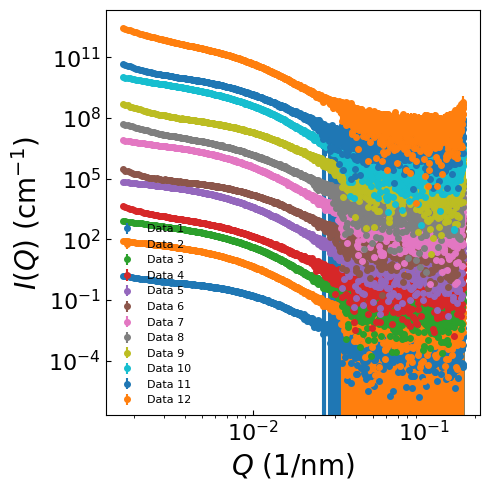

2972


In [105]:
## CVWLM7 9m15a
# Define the folder path
folder_path = './data/micelle_SAXS/'

# List all files in the folder
filenames = os.listdir(folder_path)

# Print the filenames
data_list = []
for filename in filenames:
    print(filename)
    
    # load data
    data = np.loadtxt(os.path.join(folder_path, filename), skiprows=10, delimiter=None)
    data_list.append(data)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i_d, data in enumerate(data_list):
    data = data_list[i_d]
    Q = data[:, 0]
    IQ = data[:, 1]
    IQ_er = data[:, 2]
    
    shift_factor = 10**i_d
    ax.errorbar(Q, IQ*shift_factor, yerr=IQ_er*shift_factor, fmt='o', markersize=4, label=f'Data {i_d+1}')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ (1/nm)', fontsize=20)
ax.set_ylabel(r'$I(Q)$ (cm$^{-1}$)', fontsize=20)
ax.tick_params(direction='in', labelsize=16)
ax.legend(fontsize=8, frameon=False)
plt.tight_layout()
plt.show()

print(len(Q))

## Run GPR and display result

### test on one data

current m_sigma: 1.0, log_likelihood: -464.144018216211
current m_sigma: 1.258925411794167, log_likelihood: -106.37113275307144
current m_sigma: 1.5848931924611134, log_likelihood: 111.88787502635635
current m_sigma: 1.99526231496888, log_likelihood: 240.53410981880768
current m_sigma: 2.51188643150958, log_likelihood: 311.6756999037806
current m_sigma: 3.162277660168379, log_likelihood: 345.95061315528926
current m_sigma: 3.9810717055349736, log_likelihood: 356.60208718792575
current m_sigma: 5.011872336272724, log_likelihood: 352.1181853930416
current m_sigma: 6.3095734448019325, log_likelihood: 337.9393230466335
current m_sigma: 7.943282347242816, log_likelihood: 317.55771095799713
current m_sigma: 10.0, log_likelihood: 293.2212622476204
Optimal sigma: 3.981


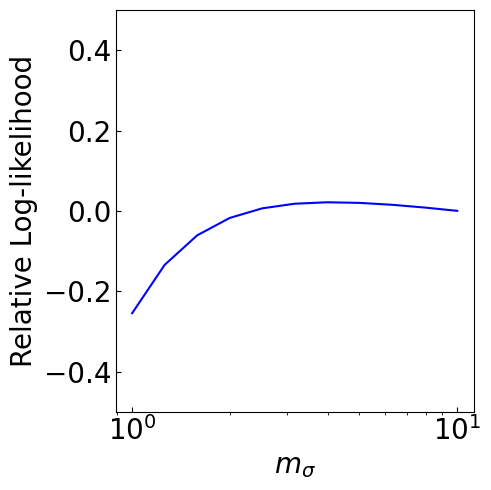

In [126]:
# === Inference and Preprocessing Parameters ===

# Kernel smoothing width (applied to transformed Q)
background_filter_width = 0.04        

# Background level used for log-like intensity transform
background_intensity_offset = 1e-5

# Flags for transformation type
use_log_I = True                    # Apply log transform to I(Q)
use_log_Q = True                     # Apply log transform to Q
lmbda = 0.2                         # RBF kernel length scale

# === Define Q transformation functions ===
if use_log_Q:
    f_Q       = lambda q: np.log(q)
    f_inv_Q   = lambda fq: np.exp(fq)
else:
    f_Q       = lambda q: q
    f_inv_Q   = lambda fq: fq

# === Define I(Q) transformation functions ===
if use_log_I:
    x_c = background_intensity_offset
    y_c = np.log(x_c)
    f_I         = lambda I: f_loglin(I, x_c=x_c)
    f_inv_I     = lambda fI: f_loglin_inv(fI, y_c=y_c)
    f_I_deriv   = lambda I: f_loglin_deriv(I, x_c=x_c)
else:
    f_I         = lambda I: I
    f_inv_I     = lambda fI: fI
    f_I_deriv   = lambda I: np.ones_like(I)

# === Result Containers ===

fig, ax = plt.subplots(figsize=(5, 5)) # for plotting optimization of m_factor
ax = plt.subplot(1, 1, 1) # for plotting optimization of m_factor
color = 'b'

# === 1. Load and preprocess noisy data ===
data = data_list[5]
q_data = data[:, 0]
I_data = data[:, 1]
I_err_data = data[:, 2].copy()

# Replace zero uncertainties with previous values
for i in range(1, len(I_err_data)):
    if I_err_data[i] == 0:
        I_err_data[i] = I_err_data[i - 1]

# Define outlier masks
index_outlier_sm = (q_data > 0.2) | (q_data < 0.001)
index_outlier = (q_data < 0.2) & (q_data > 0.001)

# === Estimate background using iterative kernel smoothing ===
from scipy.ndimage import gaussian_filter1d
I_data_clipped = I_data.copy()
# Clip I_data to be above a small positive number to avoid issues with log transform
I_data_clipped = np.clip(I_data, 1e-7, None)
if use_log_I:
    I_q_gf = gaussian_filter1d(f_I(I_data_clipped), sigma=25)
    I_q_gf = f_inv_I(I_q_gf)
else:
    I_q_gf = gaussian_filter1d(I_data_clipped, sigma=25) # rough background estimate as prior mean
# I_q_gf = np.zeros_like(q_data)
# for _ in range(5):
#     I_q_gf_i = np.zeros_like(q_data)
#     I_iter = I_data - I_q_gf
#     for i in range(len(q_data)):
#         dq = (f_Q(q_data[i]) - f_Q(q_data)) / background_filter_width
#         weights = np.exp(-0.5 * dq**2)
#         weights[index_outlier_sm] = 0
#         weights /= np.sum(weights)
#         I_q_gf_i[i] = np.sum(I_iter * weights)
#     I_q_gf += I_q_gf_i

# === 2. Optimize GPR noise scale parameter sigma ===
sigma_best = optimize_m_factor_gpr(
    q=q_data,
    I=I_data_clipped,
    I_err=I_err_data,
    I_bg=I_q_gf,
    f_I=f_I,
    f_inv_I=f_inv_I,
    f_I_deriv=lambda I: f_loglin_deriv(I, x_c=background_intensity_offset),
    f_Q=f_Q,
    lmbda=lmbda,
    ax=ax,
    color=color,
    index_eval=index_outlier,
    sigma_list=np.logspace(0, 1, 11),
    # eval likelihood only within q range
    q_min=1e-3,
    q_max=1e-2,
    # set y-limit for better visualization
    ylim=[-0.5, 0.5]
)
# sigma_best = 1
print(f'Optimal sigma: {sigma_best:.3f}')

# === 3. GPR prediction: posterior mean and uncertainty ===
I_mean_GP, I_std_GP, mu_s, std_s = gpr_posterior_predictive(
    q=q_data,
    I=I_data_clipped,
    I_err=I_err_data,
    I_bg=I_q_gf,
    sigma_best=sigma_best,
    f_I=f_I,
    f_inv_I=f_inv_I,
    f_I_deriv=lambda I: f_loglin_deriv(I, x_c=background_intensity_offset),
    f_Q=f_Q,
    lmbda=lmbda,
    index_eval=index_outlier
)


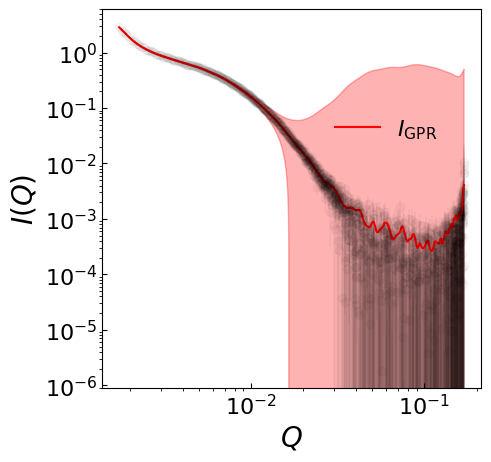

In [128]:
# === Create plot ===
fig, ax = plt.subplots(figsize=(5, 5))

# Experimental data 
ax.errorbar(q_data, I_data, yerr=I_err_data, fmt='o', color='k', ms=6,
            alpha=0.03)

# GPR prediction + uncertainty band
ax.plot(q_data, I_mean_GP, '-r', label=r'$I_\mathrm{GPR}$')
# ax.plot(q_data, I_q_gf, '-g', label=r'$I_\mathrm{BG}$')
ax.fill_between(q_data, I_mean_GP - I_std_GP, I_mean_GP + I_std_GP, color='r', alpha=0.3)
# ax.fill_between(q_data, f_inv_I(mu_s + f_I(I_q_gf) - std_s), f_inv_I(mu_s + f_I(I_q_gf) + std_s), color='r', alpha=0.3)

# === Axis and formatting ===
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim([0.2, 500])
ax.tick_params(direction='in', labelsize=16)

# Adjust to square aspect in log-log scale
xlim_log = np.log10(ax.get_xlim())
ylim_log = np.log10(ax.get_ylim())
ax.set_aspect((xlim_log[1] - xlim_log[0]) / (ylim_log[1] - ylim_log[0]))

# Legend and layout
ax.legend(frameon=False, fontsize=16, loc='lower center', bbox_to_anchor=(0.75, 0.6))
plt.tight_layout()


### iterate over all loaded data

Optimal sigma: 3.981
Optimal sigma: 3.981
Optimal sigma: 3.981
Optimal sigma: 3.981
Optimal sigma: 3.981
Optimal sigma: 3.981
Optimal sigma: 3.981
Optimal sigma: 3.981
Optimal sigma: 3.981
Optimal sigma: 3.981
Optimal sigma: 3.981
Optimal sigma: 3.981


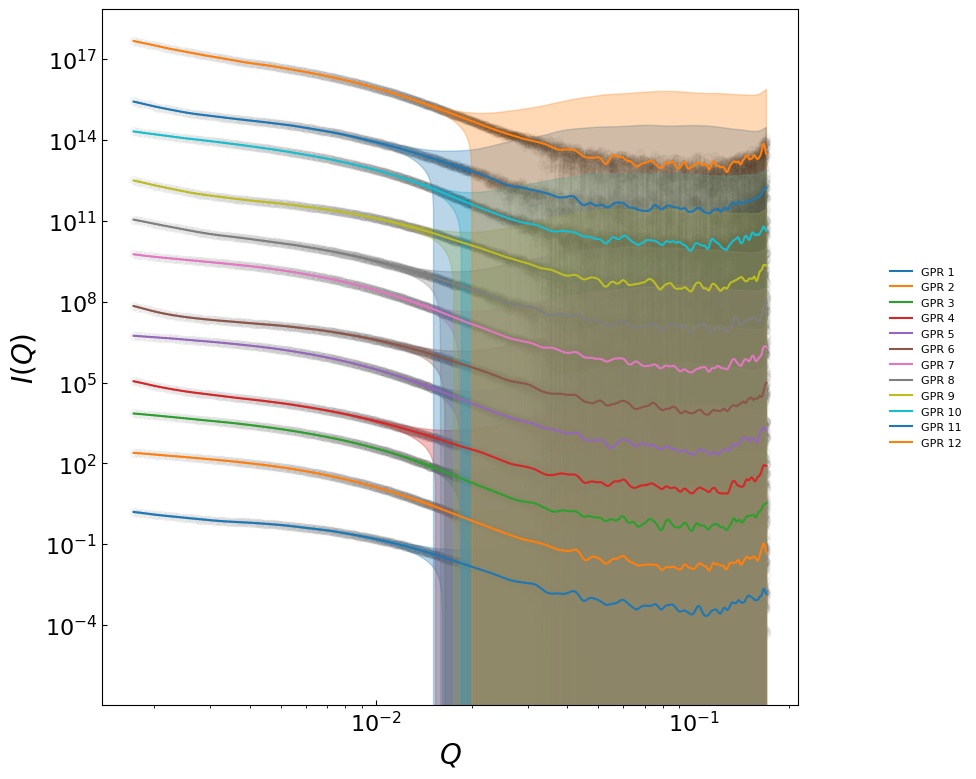

In [134]:
# === Inference and Preprocessing Parameters ===

# Kernel smoothing width (applied to transformed Q)
background_filter_width = 0.04        

# Background level used for log-like intensity transform
background_intensity_offset = 1e-5

# Flags for transformation type
use_log_I = True                    # Apply log transform to I(Q)
use_log_Q = True                     # Apply log transform to Q
lmbda = 0.2                         # RBF kernel length scale

# === Define Q transformation functions ===
if use_log_Q:
    f_Q       = lambda q: np.log(q)
    f_inv_Q   = lambda fq: np.exp(fq)
else:
    f_Q       = lambda q: q
    f_inv_Q   = lambda fq: fq

# === Define I(Q) transformation functions ===
if use_log_I:
    x_c = background_intensity_offset
    y_c = np.log(x_c)
    f_I         = lambda I: f_loglin(I, x_c=x_c)
    f_inv_I     = lambda fI: f_loglin_inv(fI, y_c=y_c)
    f_I_deriv   = lambda I: f_loglin_deriv(I, x_c=x_c)
else:
    f_I         = lambda I: I
    f_inv_I     = lambda fI: fI
    f_I_deriv   = lambda I: np.ones_like(I)

fig, ax = plt.subplots(figsize=(10, 10)) # for plotting optimization of m_factor
ax = plt.subplot(1, 1, 1) # for plotting optimization of m
# === 1. Load and preprocess noisy data ===
for i_d, data in enumerate(data_list):
    filename = filenames[i_d]
    q_data = data[:, 0]
    I_data = data[:, 1]
    I_err_data = data[:, 2].copy()

    # Replace zero uncertainties with previous values
    for i in range(1, len(I_err_data)):
        if I_err_data[i] == 0:
            I_err_data[i] = I_err_data[i - 1]

    # Define outlier masks
    index_outlier_sm = (q_data > 0.2) | (q_data < 0.001)
    index_outlier = (q_data < 0.2) & (q_data > 0.001)

    # === Estimate background using iterative kernel smoothing ===
    from scipy.ndimage import gaussian_filter1d
    I_data_clipped = I_data.copy()
    # Clip I_data to be above a small positive number to avoid issues with log transform
    I_data_clipped = np.clip(I_data, 1e-7, None)
    if use_log_I:
        I_q_gf = gaussian_filter1d(f_I(I_data_clipped), sigma=25)
        I_q_gf = f_inv_I(I_q_gf)
    else:
        I_q_gf = gaussian_filter1d(I_data_clipped, sigma=25) # rough background estimate as prior mean

    # === 2. Optimize GPR noise scale parameter sigma ===
    # sigma_best = optimize_m_factor_gpr(
    #     q=q_data,
    #     I=I_data_clipped,
    #     I_err=I_err_data,
    #     I_bg=I_q_gf,
    #     f_I=f_I,
    #     f_inv_I=f_inv_I,
    #     f_I_deriv=lambda I: f_loglin_deriv(I, x_c=background_intensity_offset),
    #     f_Q=f_Q,
    #     lmbda=lmbda,
    #     ax=ax,
    #     color=color,
    #     index_eval=index_outlier,
    #     sigma_list=np.logspace(0, 1, 11),
    #     # eval likelihood only within q range
    #     q_min=1e-3,
    #     q_max=1e-2,
    #     # set y-limit for better visualization
    #     ylim=[-0.5, 0.5]
    # )
    
    # use previously found optimal sigma
    print(f'Optimal sigma: {sigma_best:.3f}')

    # === 3. GPR prediction: posterior mean and uncertainty ===
    I_mean_GP, I_std_GP, mu_s, std_s = gpr_posterior_predictive(
        q=q_data,
        I=I_data_clipped,
        I_err=I_err_data,
        I_bg=I_q_gf,
        sigma_best=sigma_best,
        f_I=f_I,
        f_inv_I=f_inv_I,
        f_I_deriv=lambda I: f_loglin_deriv(I, x_c=background_intensity_offset),
        f_Q=f_Q,
        lmbda=lmbda,
        index_eval=index_outlier
    )
    
    shift_factor = 30**i_d
    # Plot GPR mean and uncertainty first
    line, = ax.plot(q_data, I_mean_GP*shift_factor, '-', label=f'GPR {i_d+1}', zorder=3)
    ax.fill_between(q_data, (I_mean_GP - I_std_GP)*shift_factor, (I_mean_GP + I_std_GP)*shift_factor, 
                    color=line.get_color(), alpha=0.3, zorder=2)
    
    # Plot error bars after
    ax.errorbar(q_data, I_data*shift_factor, yerr=I_err_data*shift_factor, fmt='o', color='k', ms=6,
                alpha=0.03, zorder=1)
    
    # Store results
    np.savetxt(
        f'./results/micelle_SAXS/{filename}_GPR.txt',
        np.column_stack((q_data, I_data, I_err_data, I_mean_GP, I_std_GP)),
        fmt='%.7e %.7e %.7e %.7e %.7e',
        header='Q (1/nm)    I_data (cm^-1)    I_err (cm^-1)    I_GPR (cm^-1)    I_GPR_std (cm^-1)'
    )
    
# === Axis and formatting ===
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim([0.2, 500])
ax.tick_params(direction='in', labelsize=16)

# Adjust to square aspect in log-log scale
xlim_log = np.log10(ax.get_xlim())
ylim_log = np.log10(ax.get_ylim())
ax.set_aspect((xlim_log[1] - xlim_log[0]) / (ylim_log[1] - ylim_log[0]))

# Legend and layout
ax.legend(frameon=False, fontsize=8, loc='center right', bbox_to_anchor=(1.25, 0.5))
plt.tight_layout()
